In [3]:
import time
import numpy as np
import gym
from gym import spaces
from collections import defaultdict
import math
import itertools
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Environment

In [180]:
class SmartCharging(gym.Env):
    def __init__(self, actions, cap, stuck_penalty, random_level):
        super(SmartCharging, self).__init__()
        
        self.actions = actions  
        self.cap = cap
        self.stuck_penalty = stuck_penalty
        self.random_level = random_level
        
        self.action_space = spaces.Discrete(len(self.actions))
        self.observation_space = spaces.Dict({
            'level': spaces.Discrete(self.cap+1),
            'time': spaces.Discrete(8)
        })
        
        self.state = {
            'level': 0,
            'time': 0
        }      
        
        self.done = False
        
    def reset(self):
        self.state = {
            'level': 0 if not self.random_level else np.random.randint(0, self.cap + 1),
            'time': 0
        }
        self.done = False
        return self.state
        
    def step(self, action):
        loaded = self.actions.get(action)
        reward = 0
        if loaded + self.state['level'] > self.cap: #Charging would exceed the total capacity of the battery
            reward -= cost_func(self.state['time'], self.cap - self.state['level'])
            self.state['level'] = self.cap
        else:
            reward -= cost_func(self.state['time'], loaded)
            self.state['level'] += loaded
        
        self.state['time'] += 1
        
        if self.state['time'] == 8:
            if self.state['level'] - power_consumed() >= 0:
                self.reset()
            else:
                self.reset()
                reward += self.stuck_penalty  # Add the stuck penalty directly to the reward
            self.done = True
                
        return self.state, reward, self.done, {}  # Updated the return statement with four values as expected by the Gym environment
    
def cost_func(t, p):
    '''
    This method returns the costs for charging
    @param t:  time
    @param p:  charging rate
    '''
    # alpha_time is the coefficient for time
    alpha_time = [1, 1, 1, 1, 1, 1, 1, 1]
    return alpha_time[t] * p**2

def power_consumed(mu=30, sigma=5):
    '''
    This method returns power consumed by the taxi driver
    @param mu: mean
    @param sigma: standard deviation
    '''
    return int(np.random.normal(mu, sigma, 1)[0])

def plot_q_table_3d(q_table,cap):
    
    def get_Z(key):
        #return max(q_table[key])
        return np.average(q_table[key])
        
    # battery level
    X = np.arange(cap +1)
    # time
    Y = np.arange(8)
    X_grid, Y_grid = np.meshgrid(X, Y)
    # max q-values (policy)
    Z = np.array([get_Z(key) for key in itertools.product(Y,X)]).reshape((8,cap+1))

    fig = plt.figure(figsize=(10, 10))

    # Add a 3D subplot
    #ax = [fig.add_subplot(1, 3, i, projection='3d') for i in range(1, 4)]
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot_surface(X_grid, Y_grid, -Z, cmap='viridis')

    ax.view_init(elev=30, azim=45)

    ax.set_zlabel('max Q-value')
    ax.set_ylabel('Time')
    ax.set_xlabel('Batterie level')
    plt.tight_layout()
    plt.show()

def plot_q_table_2d(q_table):
    """
    Plot average Q-values over all actions for each state in the Q-table
    
    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values for different actions.
    """
    levels = sorted(set(state[1] for state in q_table.keys()))
    times = sorted(set(state[0] for state in q_table.keys()))
    
    #default 0,0 matrix
    q_matrix = np.zeros((len(levels), len(times)))

    # Fill matrix with average Q-values
    for state_key, q_values in q_table.items():
        time, level = state_key
        if level in levels and time in times:
            level_idx = levels.index(level)
            time_idx = times.index(time)
            q_matrix[level_idx, time_idx] = np.mean(q_values)


    fig, ax = plt.subplots(figsize=(len(times), len(levels)))
    cax = ax.matshow(q_matrix, cmap='viridis')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(times)))
    ax.set_xticklabels(times)
    ax.set_yticks(np.arange(len(levels)))
    ax.set_yticklabels(levels)

    #Annotation
    for i in range(len(levels)):
        for j in range(len(times)):
            value = q_matrix[i, j]
            ax.text(j, i, f"{value:.2f}", ha='center', va='center', color='white')

    ax.set_xlabel('Time')
    ax.set_ylabel('Level')
    plt.title('Average Q-Value')
    plt.show()
    
    
def evaluate_q_table(q_table, env, num_episodes=100):
    total_reward = 0

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            state_key = (state['time'], state['level'])

            if state_key in q_table:
                action = np.argmax(q_table[state_key])
            else:
                action = env.action_space.sample()

            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            state = next_state

        total_reward += episode_reward

    average_reward = total_reward / num_episodes
    return average_reward
    
def calculate_empty_q_percentage(q_table):
    """
    Calculate the percentage of empty Q-values in the Q-table.

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values.

    Returns:
    - float: The percentage of empty Q-values in the Q-table.
    """
    total_q_values = 0
    empty_q_values = 0

    for state_key, q_values in q_table.items():
        total_q_values += len(q_values)
        empty_q_values += sum(q == 0 for q in q_values) #Define empty as q == 0

    if total_q_values == 0:
        return 0.0

    percentage_empty = (empty_q_values / total_q_values) * 100
    return percentage_empty

# Agents

## Monte Carlo 

In [207]:
class MC_Agent():
    def __init__(self, alpha, gamma, env, epsilon, epsilon_decay, epsilon_min): 
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.action_space_size = env.action_space.n 
        self.q_table = defaultdict(lambda: np.zeros(self.action_space_size))
        self.q_table_count = defaultdict(lambda: np.zeros(self.action_space_size))

    def pick_action(self, state):
        state_key = (state['time'], state['level'])  # Store state as a tuple
        if state_key in self.q_table:
            action_q_values = self.q_table[state_key] 
            return self.epsilon_greedy(action_q_values)
        else:
            return self.env.action_space.sample()
            
    def epsilon_greedy(self, action_q_values):
        policy = np.ones(self.action_space_size) * self.epsilon / self.action_space_size
        best_action = np.argmax(action_q_values)
        policy[best_action] = 1 - self.epsilon + (self.epsilon / self.action_space_size) 

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return np.random.choice(self.action_space_size, p=policy)

    def update_q_values(self, state, action, goal):
        state_key = (state['time'], state['level'])  # Store state as a tuple
        
        self.q_table_count[state_key][action] += 1
        learning_rate = self.alpha / self.q_table_count[state_key][action]
        self.q_table[state_key][action] += learning_rate * (goal - self.q_table[state_key][action])
        
    def train(self, iterations):
        for i in range(iterations):
            state = self.env.reset()
            episode = []
            done = False

            while not done:
                action = self.pick_action(state)
                old_state = state.copy()
                state, reward, done, _ = self.env.step(action)
                episode.append((old_state, action, reward))

            goal = 0
            for state, action, reward in reversed(episode):
                goal = reward + self.gamma * goal
                self.update_q_values(state, action, goal)
                
        return self.q_table

## SARSA

In [13]:
class SARSA_Agent():
    def __init__(self, alpha, gamma, env, epsilon, epsilon_decay, epsilon_min):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.action_space_size = env.action_space.n
        self.q_table = defaultdict(lambda: np.zeros(self.action_space_size))

    def pick_action(self, state):
        state_key = (state['time'], state['level'])
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state_key])
            
    def epsilon_greedy(self, action_q_values):
        policy = np.ones(self.action_space_size) * self.epsilon / self.action_space_size
        best_action = np.argmax(action_q_values)
        policy[best_action] = 1 - self.epsilon + (self.epsilon / self.action_space_size)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return np.random.choice(self.action_space_size, p=policy)

    def update_q_values(self, state, action, reward, next_state, next_action, done):
        state_key = (state['time'], state['level'])
        next_state_key = (next_state['time'], next_state['level'])

        td_target = reward + self.gamma * self.q_table[next_state_key][next_action] * (1 - done)
        td_error = td_target - self.q_table[state_key][action]
        
        self.q_table[state_key][action] += self.alpha * td_error

    def train(self, iterations):
        for i in range(iterations):
            state = self.env.reset()
            action = self.pick_action(state)
            done = False

            while not done:
                next_state, reward, done, _ = self.env.step(action)
                next_action = self.pick_action(next_state)
                self.update_q_values(state, action, reward, next_state, next_action, done)
                
                state = next_state
                action = next_action
        
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
        
        return self.q_table

## Q Learning

In [11]:
class QLearning_Agent():
    def __init__(self, alpha, gamma, env, epsilon, epsilon_decay, epsilon_min):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.action_space_size = env.action_space.n 
        self.q_table = defaultdict(lambda: np.zeros(self.action_space_size))

    def pick_action(self, state):
        state_key = (state['time'], state['level'])  # Store state as a tuple
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state_key])
            
    def epsilon_greedy(self, action_q_values):
        policy = np.ones(self.action_space_size) * self.epsilon / self.action_space_size
        best_action = np.argmax(action_q_values)
        policy[best_action] = 1 - self.epsilon + (self.epsilon / self.action_space_size) 

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return np.random.choice(self.action_space_size, p=policy)

    def update_q_values(self, state, action, reward, next_state, done):
        state_key = (state['time'], state['level'])
        next_state_key = (next_state['time'], next_state['level'])
        
        best_next_action = np.argmax(self.q_table[next_state_key])
        td_target = reward + self.gamma * self.q_table[next_state_key][best_next_action] * (1 - done)
        td_error = td_target - self.q_table[state_key][action]
        
        self.q_table[state_key][action] += self.alpha * td_error
        
    def train(self, iterations):
        for i in range(iterations):
            state = self.env.reset()
            done = False

            while not done:
                action = self.pick_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.update_q_values(state, action, reward, next_state, done)
                state = next_state
                
            # Decay epsilon after each episode
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
        
        return self.q_table


## Deep Q-Network

In [7]:
class DQN_Agent():
    def __init__(self, env, alpha, gamma, epsilon, epsilon_decay, epsilon_min, memory_size, batch_size, target_update=10):
        self.env = env
        self.state_size = 2
        self.action_size = env.action_space.n
        self.alpha = alpha
        self.gamma = gamma 
        self.epsilon = epsilon  
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.target_update = target_update
        
        # Experience replay memory
        self.memory = deque(maxlen=memory_size)

        # Q-network
        self.model = self.build_model()

        # Target Q-network
        self.target_model = self.build_model()
        self.update_target_model()

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.alpha)

    def build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)
        )
        return model

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def pick_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Exploration
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()  # Exploitation

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return 

        minibatch = random.sample(self.memory, self.batch_size)

        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = reward
            if not done:
                target += self.gamma * torch.max(self.target_model(next_state)).item()
            
            target_f = self.model(state)
            target_f[action] = target

            loss = nn.MSELoss()(self.model(state), target_f)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def generate_state_space_keys(self):
        state_space_keys = []
        for time in range(self.env.observation_space['time'].n):
            for level in range(self.env.observation_space['level'].n):
                state_space_keys.append((time, level))
        return state_space_keys

    def extract_q_table(self):
        q_table = {}
        state_space_keys = self.generate_state_space_keys()

        for state_key in state_space_keys:
            state = torch.FloatTensor(state_key).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state).numpy().flatten()
            q_table[state_key] = q_values

        return q_table

    def train(self, episodes):
        for e in range(episodes):
            state = self.env.reset()
            state = np.array([state['time'], state['level']])
            done = False
            total_reward = 0

            while not done:
                action = self.pick_action(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.array([next_state['time'], next_state['level']])
                total_reward += reward
                self.store_experience(state, action, reward, next_state, done)
                state = next_state
                self.replay()

            if e % self.target_update == 0:
                self.update_target_model()
            
            
            print(f"Episode {e+1}/{episodes} - Reward: {total_reward}, Epsilon: {self.epsilon:.2f}")

        return self.extract_q_table()


# Execution

In [221]:
actions = {i: i for i in range(23)}
env = SmartCharging(actions=actions, cap=80, stuck_penalty=-5000,random_level=True)

In [222]:
MC_q_table = MC_Agent(
    alpha=0.01, gamma=0.9, env=env, epsilon=0.1, epsilon_decay=0.9, epsilon_min=0.01
).train(10000)

In [223]:
SARSA_q_table = SARSA_Agent(
    alpha=0.01, gamma=0.9, env=env, epsilon=0.1, epsilon_decay=0.99, epsilon_min=0.01
).train(10000)

In [227]:
QLEARN_q_table = QLearning_Agent(
    alpha=0.01, gamma=0.9, env=env, epsilon=0.1, epsilon_decay=0.99, epsilon_min=0.01
).train(10000)

In [224]:
DQN_q_table = DQN_Agent(
    env=env, alpha=0.01, gamma=1, epsilon=0.2, epsilon_decay=0.99, epsilon_min=0.01, memory_size=10000, batch_size=32, target_update=10
).train(100)

Episode 1/100 - Reward: -146, Epsilon: 0.20
Episode 2/100 - Reward: -212, Epsilon: 0.20
Episode 3/100 - Reward: -232, Epsilon: 0.20
Episode 4/100 - Reward: -317, Epsilon: 0.20
Episode 5/100 - Reward: -666, Epsilon: 0.18
Episode 6/100 - Reward: -397, Epsilon: 0.17
Episode 7/100 - Reward: -754, Epsilon: 0.16
Episode 8/100 - Reward: -5000, Epsilon: 0.14
Episode 9/100 - Reward: -129, Epsilon: 0.13
Episode 10/100 - Reward: -1, Epsilon: 0.12
Episode 11/100 - Reward: -547, Epsilon: 0.11
Episode 12/100 - Reward: -666, Epsilon: 0.10
Episode 13/100 - Reward: -1, Epsilon: 0.10
Episode 14/100 - Reward: -5115, Epsilon: 0.09
Episode 15/100 - Reward: -69, Epsilon: 0.08
Episode 16/100 - Reward: -152, Epsilon: 0.08
Episode 17/100 - Reward: -5, Epsilon: 0.07
Episode 18/100 - Reward: -29, Epsilon: 0.06
Episode 19/100 - Reward: -68, Epsilon: 0.06
Episode 20/100 - Reward: -201, Epsilon: 0.05
Episode 21/100 - Reward: -16, Epsilon: 0.05
Episode 22/100 - Reward: -218, Epsilon: 0.05
Episode 23/100 - Reward: -1

In [250]:
MC_avg = evaluate_q_table(MC_q_table, env, num_episodes=100)
MC_empty = calculate_empty_q_percentage(MC_q_table)
print("Monte Carlo \n Average reward: ", MC_avg , "\n Empty Q-values: ", MC_empty, "%")
SARSA_avg = evaluate_q_table(SARSA_q_table, env, num_episodes=100)
SARSA_empty = calculate_empty_q_percentage(SARSA_q_table)
print("SARSA \n Average reward: ", SARSA_avg , "\n Empty Q-values: ", SARSA_empty, "%")
QLEARN_avg = evaluate_q_table(QLEARN_q_table, env, num_episodes=100)
QLEARN_empty = calculate_empty_q_percentage(QLEARN_q_table)
print("Q-Learning \n Average reward: ", QLEARN_avg , "\n Empty Q-values: ", QLEARN_empty, "%")
DQN_avg = evaluate_q_table(DQN_q_table, env, num_episodes=100)
DQN_empty = calculate_empty_q_percentage(DQN_q_table)
print("Deep Q-Network \n Average reward: ", DQN_avg , "\n Empty Q-values: ", DQN_empty, "%")

Monte Carlo 
 Average reward:  -121.27 
 Empty Q-values:  26.6304347826087 %
SARSA 
 Average reward:  -1350.3 
 Empty Q-values:  95.12733345261526 %
Q-Learning 
 Average reward:  -1650.0 
 Empty Q-values:  95.19293851016877 %
Deep Q-Network 
 Average reward:  -83.75 
 Empty Q-values:  0.0 %


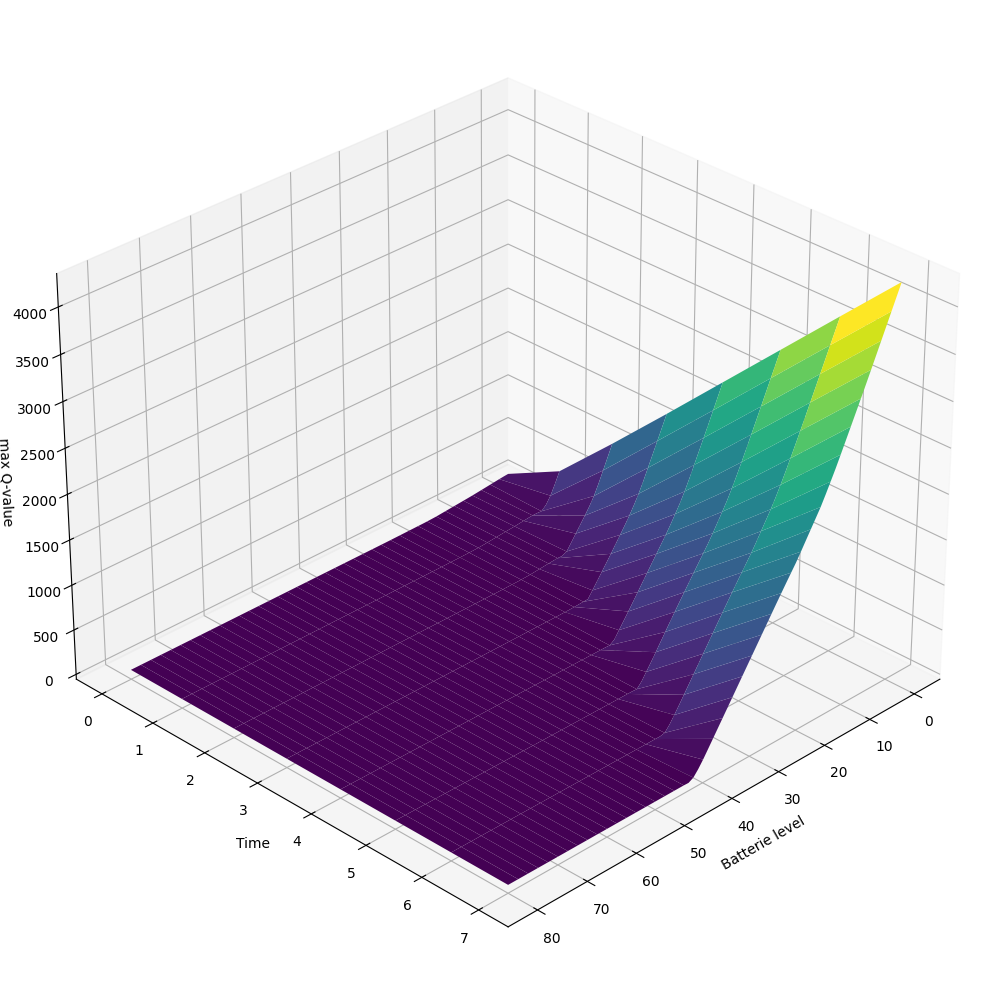

In [251]:
plot_q_table_3d(DQN_q_table,env.cap)

Monte Carlo, Q-learning (double) , Deep Q-Network, SARSA